In [1]:
import numpy as np
from astropy.io import fits 
import matplotlib.pyplot as plt 

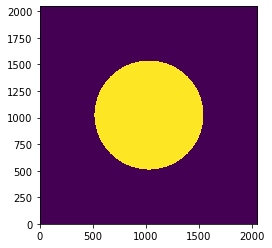

In [2]:
#make the PSF:
N = 2048 #number of points to plot   
a = 8.0 #total size of the grid, in meters
aperture = np.zeros([N,N]) #array containing the aperture (1 will be where light can enter, zero where it cannot)

x = np.linspace(-a/2.0,a/2.0,N) #x grid referent to origin at center 
y = np.linspace(-a/2.0,a/2.0,N) #y grid referent to origin at center 
R = 2.0 #radius of our telescope, this is one m, like SST :) 

#make circular aperture
for i in range(0,N):
    for j in range(0,N):
        if ((x[i]**2.0 + y[j]**2.0)**0.5 <= R):
            aperture[i,j] = 1.0

plt.imshow(np.real(aperture),origin='lower') #plot the aprerture

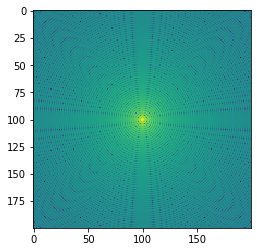

In [3]:
# Now, from the (complex) aperture, we calculate the FFT:
aperture_fft = np.fft.fft2(aperture)
PSF = np.abs(aperture_fft)
PSF = PSF**2.0

# we need to rearange this:
PSF = np.fft.fftshift(PSF,axes=(0,1))

#we are only going to be interested in the innermost part of the PSF
N_small = 200
PSF = PSF[N//2-N_small//2:N//2+N_small//2,N//2-N_small//2:N//2+N_small//2]
# we plot psf in the log scale
plt.imshow(np.log10(PSF[:,:]))

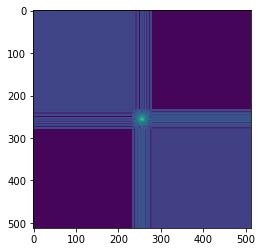

In [4]:
# At the moment, our x (and y) scales for the PSF are in pixels, so to speak. Realistically they should be in wave numbers
# Then we need to transform these wavenumbers into angles. We don't have time to clarify this but transformation is done in
# the following way:
x_step = a / N #step of the original image
xf = np.linspace(-1.0/(2.0*x_step),1.0/(2.0*x_step), N) #space of spatial frequencies
llambda = 630E-9 # wavelength we are observing at
theta = xf*llambda * 206265 #transform the spatial frequencies to angles
theta = theta[N//2-N_small//2:N//2+N_small//2] #select the appropriate part for the narrowed down PSF
norm = np.amax(PSF) # we want to normalize the psf with respect to maximum first: 
PSF /= norm
scale = 48.0/725.0 #in arcsec
grid_interpolate = np.linspace(-256,256,512)*scale

from scipy import interpolate
f = interpolate.interp2d(theta,theta,PSF)
psf_interpolated = f(grid_interpolate,grid_interpolate)
plt.imshow(np.log10(psf_interpolated))

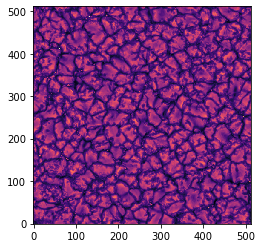

In [5]:
# load the image from file
image = fits.open("synth_sun.fits")[0].data
plt.imshow(image,origin='lower',cmap='magma')

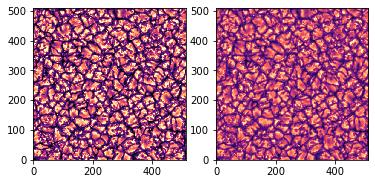

In [6]:
# now finally, convolve
from scipy.signal import convolve2d

# we have to normalize again so that the surface of the psf is one 
psf_interpolated /= np.sum(psf_interpolated)

image_smeared = convolve2d(image,psf_interpolated,mode='same',boundary='symm') 

mean = np.mean(image)
image /= mean
image_smeared /=mean

##convolution messes up with our edges, so we can get rid of them:
#image = image[50:-50,50:-50]
#image_smeared = image_smeared[32:-32,32:-32]

plt.subplot(121)
plt.imshow(image,vmin=0.7,vmax=1.3,origin='lower',cmap='magma')
plt.subplot(122)
plt.imshow(image_smeared,vmin=0.7,vmax=1.3,origin='lower',cmap='magma')

For deconvolve this we have: 

-First applied fourier transform $$h=f*g \Longrightarrow H=FG$$ 
-later we obtain $$F=H/G$$
-finally aplied inverse fourier transform to obtain $$f$$

(512, 512)


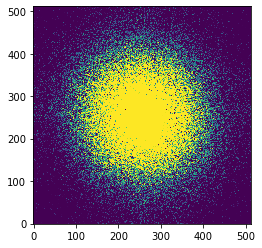

In [7]:
Image_smeared = np.fft.fft2(image_smeared)
Image_smeared = np.fft.fftshift(Image_smeared)
Image_smeared_plot = np.abs(Image_smeared)
print(np.shape(Image_smeared))

M = 512
m = 10
#Image_smeared = Image_smeared[M//2-m//2:M//2+m//2,M//2-m//2:M//2+m//2]

plt.imshow(np.log10(Image_smeared_plot),vmin=0.7,vmax=1.3,origin='lower')

(512, 512)


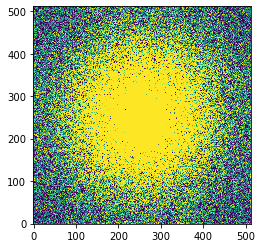

In [8]:
Image = np.fft.fft2(image)
Image = np.fft.fftshift(Image)
Image_plot = np.abs(Image)
print(np.shape(Image))

plt.imshow(np.log10(Image_plot),vmin=0.7,vmax=1.3,origin='lower')

(512, 512)


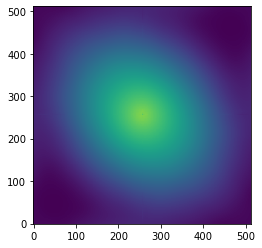

In [9]:
PSF_interpolate = np.fft.fft2(psf_interpolated)
PSF_interpolate = np.fft.fftshift(PSF_interpolate)
PSF_interpolate_plot = np.abs(PSF_interpolate)
print(np.shape(PSF_interpolate))

plt.imshow(np.log10(PSF_interpolate_plot),origin='lower')

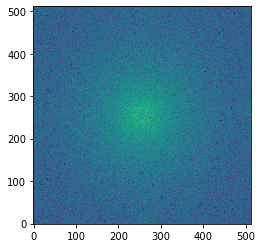

In [10]:
#Image_smeared = np.reshape(Image_smeared,(64,64))
Image = Image_smeared/PSF_interpolate
Image_plot = np.abs(Image)
plt.imshow(np.log10(Image_plot),origin='lower')

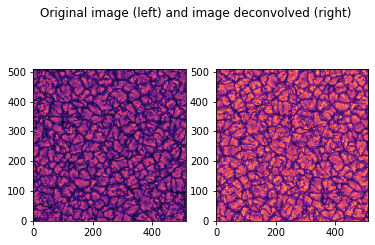

In [36]:
image_if = np.fft.ifft2(Image)  # Original image obtained from deconvolution of image_smeared and psf_interpolate
image = fits.open("synth_sun.fits")[0].data
#image_if /= mean
plt.suptitle('Original image (left) and image deconvolved (right)')
plt.subplot(121)
plt.imshow(image,origin='lower',cmap='magma')
plt.subplot(122)
plt.imshow(np.log10(np.abs(image_if)),origin='lower',cmap='magma')

Deconvolution of an image using a Wiener algorithm

(512, 512)


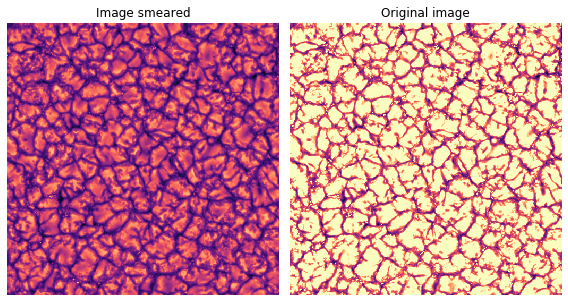

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, data, restoration

astro = image_smeared
from scipy.signal import convolve2d as conv2
psf = psf_interpolated
#astro = conv2(astro, psf, 'same')
#astro += 0.1 * astro.std() * np.random.standard_normal(astro.shape)

deconvolved, _ = restoration.unsupervised_wiener(astro, psf)
print(np.shape(deconvolved))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.magma()

ax[0].imshow(np.log10(np.abs(astro)))
ax[0].axis('off')
ax[0].set_title('Image smeared')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Original image')

fig.tight_layout()

plt.show()

(512, 512)


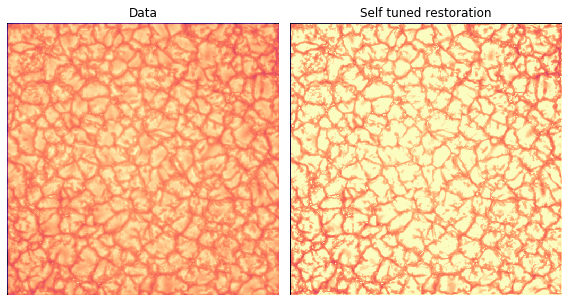

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, data, restoration

astro = image
from scipy.signal import convolve2d as conv2
psf = psf_interpolated
astro = conv2(astro, psf, 'same')
#astro += 0.1 * astro.std() * np.random.standard_normal(astro.shape)

deconvolved, _ = restoration.unsupervised_wiener(astro, psf)
print(np.shape(deconvolved))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.magma()

ax[0].imshow(np.log10(np.abs(astro)))
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()